In [ ]:
!pip install --quiet torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.5/237.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 3.0 MB/s eta 0:00:00


In [ ]:
%pip install --quiet unet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import dependencies
# Here we load the packages that we need for the rest of the practical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import torch 
import torch.nn as nn
import torch.optim as optim
import time
import plotly.express as px
import pandas as pd
import torchio as tio
import os
import tempfile
from scipy import stats
import random

# Mutli-Scanner Generalization in MRI Segmentation via Discrepancy Minimization



## 1. Introduction
The goal of this study is to improve the generalization of MRI segmentation models when dealing with data collected from different scanners. We will explore various training strategies and domain adaptation techniques to enhance the performance of the models across domains. The [`dataset`](https://brain-development.org/ixi-dataset/) used in this study consists of MRI data from three hospitals: Guys and IOP with 1.5T scanners, and HH with a 3T scanner. We create source dataset from Guys and IOP using 1.5T scanners, and target dataset from HH. The goal is to investigate generalization methods to determine the best multi-scanner generalization method. We will compare the following approaches: 

1. Direct transfer of a model trained on the source domain
2. Training a model from scratch on the target domain (very limited data)
3. Using transfer learning to fine-tune a model from the source domain to the target domain
4. Training a model on all data with intensity normalization applied. 

We aim to identify the most effective method for improving multi-scanner generalization in MRI segmentation.

In the end, we propose a novel training regularizer with combined MMD loss


## 2. Data Loading and Preprocessing
In this section, we load the MRI data from the three hospitals and preprocess it. We apply different intensity normalization methods, such as histogram standardization and Z-normalization, to reduce variability in intensity values across different scans and scanners. This preprocessing step aims to enhance the model's ability to learn relevant features and generalize across different sources of data.


### Loading raw data 
The `raw_data` dictionary contains data for three hospitals: Guys, HH, and IOP. Each hospital has data for two types: "X" and "label". The "train" data is a numpy array of shape (N, 40, 128, 128), representing the 3D MRI scan of brains. The "label" data is also a numpy array of shape (N, 40, 128, 128), representing the brain extraction of the corresponding scan. Additionally, each hospital has an "ids" numpy array of shape (N,), which contains unique identifiers for each sample.

For each hospital, number of samples is (317, 176, 71)

In [ ]:
def file_location(hospital, d_type):
  base_path = '/content/drive/MyDrive/DLH_mini_project/data/brain_extraction/'
  return base_path + d_type + '_' + hospital + '.npy'

hospitals = ['Guys','HH','IOP']
N_samples = [317, 176, 71]

raw_data = {hospital_name: {'X': np.load(file_location(hospital_name, 'X')),
                            'label': np.load(file_location(hospital_name, 'y')),
                            'ids': np.load(file_location(hospital_name, 'ids'))} 
            for hospital_name in hospitals}

In [ ]:
# Loop over the hospitals and print the size of each data type
for hospital in raw_data:
    train_size = raw_data[hospital]['X'].shape
    label_size = raw_data[hospital]['label'].shape
    id_size = raw_data[hospital]['ids'].shape
    print(f"{hospital}: train size={train_size}, label size={label_size}, id size={id_size}")

Guys: train size=(317, 40, 128, 128), label size=(317, 40, 128, 128), id size=(317,)
HH: train size=(176, 40, 128, 128), label size=(176, 40, 128, 128), id size=(176,)
IOP: train size=(71, 40, 128, 128), label size=(71, 40, 128, 128), id size=(71,)


#### Are there intersections of patient ids from different hospitals? -> No

In [ ]:
def find_common_ids(hospital1, hospital2):
    return set(hospital1['ids']).intersection(set(hospital2['ids']))

combinations = [('Guys', 'HH'), ('Guys', 'IOP'), ('HH', 'IOP'), ('all',)]
common_data = {}

for combo in combinations:
    if combo[0] == 'all':
        common_ids = find_common_ids(raw_data['Guys'], raw_data['HH']).intersection(set(raw_data['IOP']['ids']))
        key = "all"
    else:
        common_ids = find_common_ids(raw_data[combo[0]], raw_data[combo[1]])
        key = f"{combo[0]}+{combo[1]}"
    
    common_data[key] = {"ids": [], "X": [], "label": []}
    if common_ids:
        for hospital in hospitals:
            for idx, subject_id in enumerate(raw_data[hospital]['ids']):
                if subject_id in common_ids:
                    common_data[key]["ids"].append(subject_id)
                    common_data[key]["X"].append(raw_data[hospital]['X'][idx])
                    common_data[key]["label"].append(raw_data[hospital]['label'][idx])

# Convert lists to numpy arrays
for key in common_data:
    common_data[key]["X"] = np.array(common_data[key]["X"])
    common_data[key]["label"] = np.array(common_data[key]["label"])

# Print the results
for key, data in common_data.items():
    print(f"{key}: ids={len(data['ids'])}, X size={data['X'].shape}, label size={data['label'].shape}")


Guys+HH: ids=0, X size=(0,), label size=(0,)
Guys+IOP: ids=0, X size=(0,), label size=(0,)
HH+IOP: ids=0, X size=(0,), label size=(0,)
all: ids=0, X size=(0,), label size=(0,)


### Visualize 

Visualize the data in 2D and 3D

#### Axial, Coronal, Sagittal Views

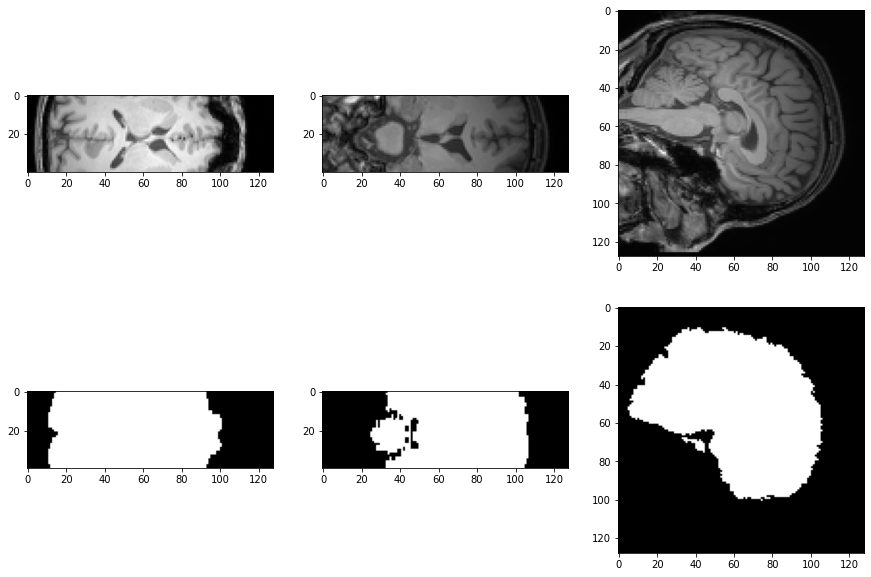

In [ ]:
# Lets first see what the values are
# Extract the scan and label data from the first sample in the Guys data
scan_data = raw_data['HH']['X'][0]
label_data = raw_data['HH']['label'][0]

# Create subplots for the axial, coronal, and sagittal views
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), subplot_kw={'aspect': 'equal'})

# Display the axial view of the scan data
ax[0, 0].imshow(scan_data[:, :, 64], cmap='gray')

# Display the axial view of the label data
ax[1, 0].imshow(label_data[:, :, 64], cmap='gray')

# Display the coronal view of the scan data
ax[0, 1].imshow(scan_data[:, 64, :], cmap='gray')

# Display the coronal view of the label data
ax[1, 1].imshow(label_data[:, 64, :], cmap='gray')

# Display the sagittal view of the scan data
ax[0, 2].imshow(scan_data[20, :, :], cmap='gray')

# Display the sagittal view of the label data
ax[1, 2].imshow(label_data[20, :, :], cmap='gray')

plt.show()

#### 3D View

These 3D images are generated using function below. For resource concerns, we are not running it everytime. 
![schematic](https://drive.google.com/uc?id=1MMc7mz-0FYSrHujbJ4I-iZ1WPtc3hOTa)

![schematic](https://drive.google.com/uc?id=1KSt_K23mLOnco4AvVqeucZVZQW7iMF3c)

In [ ]:
run_3D = False
if run_3D:
  import plotly.graph_objects as go
  # Visualize the brain for the first sample in the training data for the HH hospital
  hh_train_data = raw_data['Guys']['X']
  brain_data = hh_train_data[0]
  x, y, z = np.mgrid[0:brain_data.shape[0], 0:brain_data.shape[1], 0:brain_data.shape[2]]
  fig = go.Figure(data=go.Volume(x=x.flatten(), y=y.flatten(), z=z.flatten(),
                                  value=brain_data.flatten(),
                                  isomin=np.min(brain_data), isomax=np.max(brain_data),
                                  opacity=0.1, surface_count=17,
                                  colorscale='Viridis'))
  fig.show()

  # Visualize the segmentation for the first sample in the training data for the HH hospital
  hh_train_label = raw_data['Guys']['label']
  label_data = hh_train_label[0]
  x, y, z = np.mgrid[0:label_data.shape[0], 0:label_data.shape[1], 0:label_data.shape[2]]
  fig = go.Figure(data=go.Scatter3d(x=x.flatten()[label_data.flatten() > 0], 
                                    y=y.flatten()[label_data.flatten() > 0], 
                                    z=z.flatten()[label_data.flatten() > 0], 
                                    mode='markers', marker=dict(size=1, color=label_data.flatten()[label_data.flatten() > 0])))
  fig.show()

### [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html)

We will create two dataset to test the generalizability of our model each for the source and target domain. 
To do so, we will use the torchio.data.SubjectsDataset:
 1. Save images tensors from raw_data to image path
 2. Load the image path to create two SubjectsDataset

In [ ]:
create_mri = True
create_label = True

# Define the output directory for the images
output_dir_mri = '/content/drive/MyDrive/DLH_mini_project/data/subject_dataset/mri/'
output_dir_label = '/content/drive/MyDrive/DLH_mini_project/data/subject_dataset/label/'

# Create the output directory if it does not exist
if not os.path.exists(output_dir_mri):
  os.makedirs(output_dir_mri)
else: 
  create_mri = False
if not os.path.exists(output_dir_label):
  os.makedirs(output_dir_label)
else: 
  create_label = False

# Define the file extension and prefix
file_ext = '.nii.gz'
file_prefix_mri = 'mri'
file_prefix_label = 'label'
file_hospital_info = 'HH'

# Create a list to store the file paths
file_list_mri = []
file_list_mri_source = []
file_list_mri_target = []
file_list_label = []


# Create a split dataset for each hospital 
split_subjects_dataset = {hospital_name: None for hospital_name in hospitals}

# Create a total dataset
subjects_dataset = None

# Loop over the tensors and save each one as an image file
for hospital_name in hospitals:
    # Create a list to store the subjects
    subjects_list = []
    file_hospital_info = hospital_name
    raw_mri = raw_data[hospital_name]['X']
    raw_labels = raw_data[hospital_name]['label']
    for i in range(len(raw_mri)):
      # Extract the MRI and segmentation data for the current scan
      mri_image = np.expand_dims(raw_mri[i], axis=0)
      label_image = np.expand_dims(raw_labels[i], axis=0)

      # Create a ScalarImage and a LabelMap from the scan data
      mri_image = tio.ScalarImage(tensor=torch.tensor(mri_image))
      label_image = tio.LabelMap(tensor=torch.tensor(label_image))

      # Create a Subject object from the ScalarImage and LabelMap
      subject = tio.Subject(mri=mri_image, seg=label_image)

      # Append the Subject to the list of subjects
      subjects_list.append(subject)

      # Save the image to a temporary file
      with tempfile.NamedTemporaryFile(suffix=file_ext) as f:
          file_path_mri = os.path.join(output_dir_mri, f'IXI-{hospital_name}-{i:03d}_{file_prefix_mri}{file_ext}')
          if create_mri:
            mri_image.save(file_path_mri)
          file_path_label = os.path.join(output_dir_label, f'IXI-{hospital_name}-{i:03d}_{file_prefix_label}{file_ext}')
          if create_label:
            label_image.save(file_path_label)
          # Append the file path to the list
          file_list_mri.append(file_path_mri)
          if hospital_name == "Guys" or hospital_name == "IOP":
            file_list_mri_source.append(file_path_mri)
          else:
            file_list_mri_target.append(file_path_mri)
          file_list_label.append(file_path_label)

      # Set the value for split dataset
      split_subjects_dataset[hospital_name] = subjects_list

# Create a SubjectsDataset from the subjects in the split_subjects_dataset
subjects = tio.SubjectsDataset([subject for subjects_list in split_subjects_dataset.values() for subject in subjects_list])
source_subjects = tio.SubjectsDataset(split_subjects_dataset['Guys'] + split_subjects_dataset['IOP'])
target_subjects = tio.SubjectsDataset(split_subjects_dataset['HH'])


print(f'Number of saved mri files: {len(file_list_mri)}, number of saved label files: {len(file_list_label)}')
print(f'Number of saved mri files from source domain (Guys + IOP) : {len(file_list_mri_source)}') 
print(f'number of saved mri files from target domain (HH) : {len(file_list_mri_target)}')
for hospital_name, subjects in split_subjects_dataset.items():
    print(f'Hospital: {hospital_name}, Number of subjects: {len(subjects)}')
print(f'Number of subjects in combined dataset: {len(subjects)}')
print(f'Number of subjects in source dataset (Guys + IOP): {len(source_subjects)}')
print(f'Number of subjects in target dataset (HH): {len(target_subjects)}' )


Number of saved mri files: 564, number of saved label files: 564
Number of saved mri files from source domain (Guys + IOP) : 388
number of saved mri files from target domain (HH) : 176
Hospital: Guys, Number of subjects: 317
Hospital: HH, Number of subjects: 176
Hospital: IOP, Number of subjects: 71
Number of subjects in combined dataset: 71
Number of subjects in source dataset (Guys + IOP): 388
Number of subjects in target dataset (HH): 176


#### Visualize tio subject dataset

We can visualize the difference in resolution

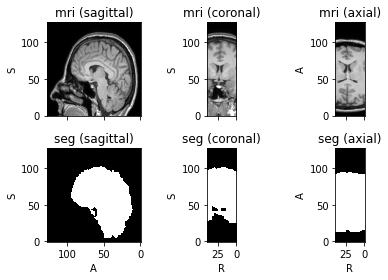

In [ ]:
one_source = source_subjects[0]
one_source.plot()

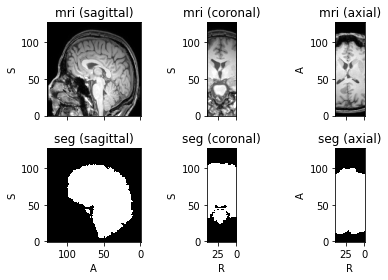

In [ ]:
one_target = target_subjects[0]
one_target.plot()

### Transform

We will use code from [torchio](https://www.sciencedirect.com/science/article/pii/S0169260721003102?via%3Dihub) for the transformation. You can find the code in [torchio tutorial](https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=SE3mwfxsnp9G).

We will use the [`HistogramStandardization`](https://torchio.readthedocs.io/transforms/preprocessing.html#histogramstandardization),  [`ZNormalization`](https://torchio.readthedocs.io/transforms/preprocessing.html#znormalization), [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#resample) transforms to normalize our images 
intensity.

1. Based on orginial [`HistogramStandardization Paper`](https://biomedical-engineering-online.biomedcentral.com/articles/10.1186/s12938-015-0064-y): The normalization algorithm includes two main steps: (1) intensity scaling (IS), where, for the high-quality reference image, the intensities of the image are first rescaled to a range between the low intensity region (LIR) value and the high intensity region (HIR) value; and (2) histogram normalization (HN),where the histogram of low-quality image as input image is stretched to match the histogram of the reference image, so that the intensity range in the normalized image will also lie between LIR and HIR


2. [`ZNormalization`](https://torchio.readthedocs.io/transforms/preprocessing.html#znormalization): Subtract mean and divide by standard deviation.

3. [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#resample): Resample image to a different physical space. We will resample image to 'T1' space


#### Visulize the intensity before any normalization

This Histogram is generated by the below function, for resource concerns, we will not run it everytime. ![schematic](https://drive.google.com/uc?id=1tclrRvNM9fo9czjiseb_S_jVCZH53SXj)

In [ ]:
def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

def plot_subject_dataset(subject_dataset, transform=None, title='Original histograms of all samples',
                         x_range=(-100, 2000), y_range=(0, 0.004)):
    fig, ax = plt.subplots(dpi=100)
    for hospital_name, dataset in subject_dataset.items():
        if hospital_name == 'HH':
            color = 'red'
        elif hospital_name == 'Guys':
            color = 'green'
        elif hospital_name == 'IOP':
            color = 'blue'
        else:
            color = None
        for i in range(len(dataset)):
            mri = dataset[i]
            if transform is not None:
                mri = transform(mri)
            plot_histogram(ax, mri['mri'].data, color=color)
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])
    ax.set_title(title)
    ax.set_xlabel('Intensity')
    ax.grid()

run_plot = False
if run_plot:
  plot_subject_dataset(split_subjects_dataset)

#### Train landmarks for [`HistogramStandardization`](https://torchio.readthedocs.io/transforms/preprocessing.html#histogramstandardization)

1. Train landmarks for the entire dataset: this implies that we have information about all scanners during training

2. Train landmarks for the source dataset: this implies that we do not have information about the target domain, which is more realistic in healthcare settings

In [ ]:
histogram_landmarks_path = '/content/drive/MyDrive/DLH_mini_project/data/landmarks.npy'
histogram_landmarks_path_source = '/content/drive/MyDrive/DLH_mini_project/data/landmarks_source.npy'
def generate_landmark(path, file_list):
  if not os.path.exists(path):
      landmarks = tio.HistogramStandardization.train(
          file_list,
          output_path=path,
      )
      np.set_printoptions(suppress=True, precision=3)
  else:
      landmarks = np.load(path)
  return landmarks

landmarks = generate_landmark(histogram_landmarks_path, file_list_mri)
landmarks_source = generate_landmark(histogram_landmarks_path_source, file_list_mri_source)
print('Loaded landmarks:', landmarks)
print('\nLoaded landmarks for source domain:', landmarks_source)

Loaded landmarks: [-3.46944695e-18  5.29333340e-02  3.01223567e-01  7.44389347e-01
  2.08720521e+00  1.22783896e+01  2.82745723e+01  4.23823001e+01
  5.31102594e+01  5.77667227e+01  6.26073218e+01  7.27332028e+01
  1.00000000e+02]

Loaded landmarks for source domain: [-8.67361738e-18  6.28712349e-02  3.37385378e-01  8.26928297e-01
  2.29722623e+00  1.30020199e+01  2.83333787e+01  4.14377180e+01
  5.08683310e+01  5.49824410e+01  5.94246811e+01  6.84090956e+01
  1.00000000e+02]


#### Create transformations

In [ ]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

resample_transform = tio.Resample(2)  

#### Visualize intensity after [`HistogramStandardization`](https://torchio.readthedocs.io/transforms/preprocessing.html#histogramstandardization)

![schematic](https://drive.google.com/uc?id=16unbpVF29VAbtrN0HjcawYS1qZVZk7cc)

In [ ]:
run_plot = False
if run_plot:
  plot_subject_dataset(split_subjects_dataset, transform = histogram_transform, 
                       title = 'Histograms of all samples after HistogramStandardization',
                       x_range=(0, 140), y_range=(0, 0.02))

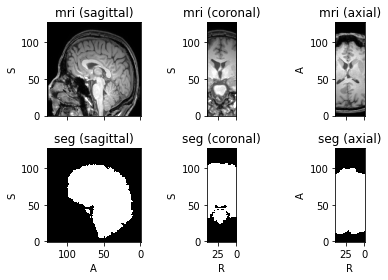

In [ ]:
histogram_standardized_one_subject = histogram_transform(one_target)
histogram_standardized_one_subject.plot()

#### Visulaize after [`ZNormalization`](https://torchio.readthedocs.io/transforms/preprocessing.html#znormalization)

![schematic](https://drive.google.com/uc?id=1tSFamVVZ5cnMV4bQCnvak0ayG2mdxKHD)


In [ ]:
run_plot = False
if run_plot:
  plot_subject_dataset(split_subjects_dataset, transform = znorm_transform, 
                       title = 'Histograms of all samples after ZNormalization', 
                       x_range=(0, 140), y_range=(0, 0.02))

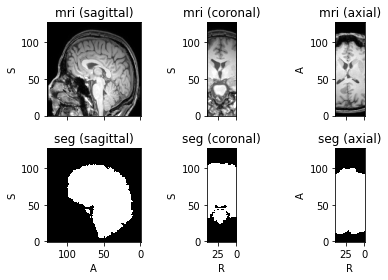

In [ ]:
znormalized_one_subject = znorm_transform(one_target)
znormalized_one_subject.plot()

#### Visualize after [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#resample)

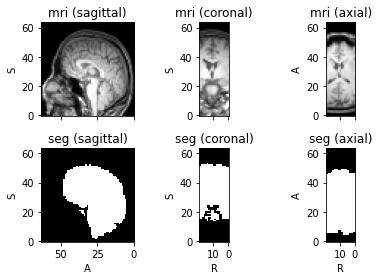

In [ ]:
resampled_one_subject = resample_transform(one_target)
resampled_one_subject.plot()

#### Defining Training Validation  Testing Transform

1. [`ToCanonical`](https://torchio.readthedocs.io/transforms/preprocessing.html#tocanonical): Converts the input image to a canonical orientation (RAS).
2. [`Resample`](https://torchio.readthedocs.io/transforms/preprocessing.html#resample): Resamples the image to the given target resolution.
3. [`RandomMotion`](https://torchio.readthedocs.io/transforms/augmentation.html#randommotion): Simulates random subject motion, which can help make the model more robust to motion artifacts.
4. HistogramStandardization: Applies histogram standardization, which can improve the model's performance when handling images from different scanners.
5. [`RandomBiasField`](https://torchio.readthedocs.io/transforms/augmentation.html#randombiasfield): Simulates random bias fields, which can help make the model more robust to intensity inhomogeneities.
6. ZNormalization: Normalizes the intensity values using z-score normalization.
7. [`RandomNoise`](https://torchio.readthedocs.io/transforms/augmentation.html#randomnoise): Adds random Gaussian noise to the image, which can help make the model more robust to noise in MRI scans.
8. [`RandomFlip`](https://torchio.readthedocs.io/transforms/augmentation.html#randomflip): Randomly flips the image along one or more axes, which can help increase the variability of the training data.
9. OneOf([`RandomAffine`](https://torchio.readthedocs.io/transforms/augmentation.html#randomaffine), [`RandomElasticDeformation`](https://torchio.readthedocs.io/transforms/augmentation.html#randomelasticdeformation)): Applies either a random affine transformation with 80% probability or a random elastic deformation with 20% probability, which can help improve the model's robustness to various deformations.

In [ ]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(num_control_points=5, max_displacement=2): 0.2,
    }),
    znorm_transform,
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    znorm_transform,
    tio.OneHot(),
])


training_transform_w_hstd = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    # tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(num_control_points=5, max_displacement=2): 0.2,
    }),
    histogram_transform,
    znorm_transform,
    tio.OneHot(),
])

validation_transform_w_hstd = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    histogram_transform,
    znorm_transform,
    tio.OneHot(),
])



In [ ]:
testing_transform = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(num_control_points=5, max_displacement=2): 0.2,
    }),
    histogram_transform,
    znorm_transform,
    tio.OneHot(),
])

testing_transform_w_hstd = tio.Compose([
    tio.ToCanonical(),
    resample_transform,
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    histogram_transform,
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(num_control_points=5, max_displacement=2): 0.2,
    }),
    znorm_transform,
    tio.OneHot(),
])

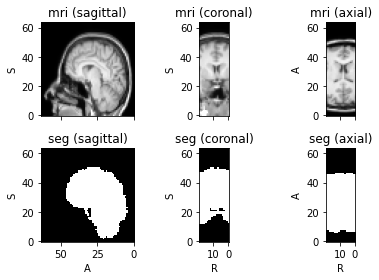

In [ ]:
train_transform_subject = training_transform(one_source)
train_transform_subject.plot()

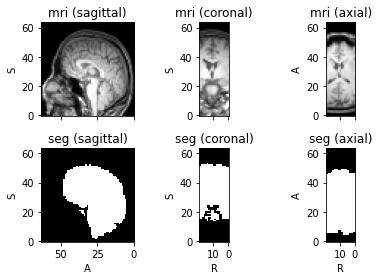

In [ ]:
validate_transform_subject = validation_transform(one_target)
validate_transform_subject.plot()

In [ ]:
print("Shape of the original input:", one_source['mri'])
print("Shape of the transformed input:", train_transform_subject['mri'])
print("Shape of the original input:", one_source['seg'])
print("Shape of the transformed input:", train_transform_subject['seg'])
print(one_source['seg'])

Shape of the original input: ScalarImage(shape: (1, 40, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.DoubleTensor; memory: 5.0 MiB)
Shape of the transformed input: ScalarImage(shape: (1, 20, 64, 64); spacing: (2.00, 2.00, 2.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 320.0 KiB)
Shape of the original input: LabelMap(shape: (1, 40, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.DoubleTensor; memory: 5.0 MiB)
Shape of the transformed input: LabelMap(shape: (2, 20, 64, 64); spacing: (2.00, 2.00, 2.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 640.0 KiB)
LabelMap(shape: (1, 40, 128, 128); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.DoubleTensor; memory: 5.0 MiB)



## 3. Methodology
We will investigate various training strategies and domain adaptation techniques to improve the generalization of MRI segmentation models across different scanners. These approaches include:


### 3.0 Set Up

#### Model - [U-Net](https://arxiv.org/abs/1505.04597), in particular, [3D U-Net](https://arxiv.org/abs/1606.06650)

The U-Net architecture is a 3D convolutional neural network designed for semantic segmentation tasks. It consists of an encoder-decoder structure with skip connections. The architecture can be briefly described as follows:

1. Encoder: The encoder consists of 2 encoding blocks, with each block containing two convolutional layers followed by batch normalization and PReLU activation. Max-pooling is used for downsampling between the blocks.
2. Bottom block: This block acts as the bottleneck of the network, containing two convolutional layers followed by batch normalization and PReLU activation.
3. Decoder: The decoder consists of 2 decoding blocks. Each block upsamples the input using trilinear upsampling, concatenates it with the corresponding skip connection from the encoder, and then applies two convolutional layers followed by batch normalization and PReLU activation.
4. Classifier: A 1x1x1 convolutional layer is used as the final classifier to output the segmentation map.
The model has the following characteristics:

Input channels: 1

Output classes: 2

Dimensions: 3

Number of encoding blocks: 3

Number of output channels in the first layer: 8

Normalization: Batch normalization

Upsampling type: Linear

Padding: True

Activation: PReLU

In [ ]:
from unet import UNet
def get_model():
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )
    return model

In [ ]:
print(get_model().encoder)
print(get_model().bottom_block)
print(get_model().decoder)
print(get_model().classifier)

Encoder(
  (encoding_blocks): ModuleList(
    (0): EncodingBlock(
      (conv1): ConvolutionalBlock(
        (conv_layer): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (activation_layer): PReLU(num_parameters=1)
        (block): Sequential(
          (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): PReLU(num_parameters=1)
        )
      )
      (conv2): ConvolutionalBlock(
        (conv_layer): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (norm_layer): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation_layer): PReLU(num_parameters=1)
        (block): Sequential(
          (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
        )
      )

#### Dice Loss

In [ ]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, epsilon=1e-9):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        target = target.float()

        intersection = (pred * target).sum(dim=(2, 3, 4))  
        cardinality = (pred + target).sum(dim=(2, 3, 4))  

        loss = 1 - (2. * intersection + self.epsilon) / (cardinality + self.epsilon)
        return loss.mean()

In [ ]:
def get_dice_score_list(pred_list, true_list, epsilon=1e-9):
    num_samples = len(pred_list)
    dice_scores = []
    
    for i in range(num_samples):
        prediction = pred_list[i]
        target = true_list[i]
        intersection = (prediction * target).sum(axis=(1, 2, 3))
        cardinality = (prediction + target).sum(axis=(1, 2, 3))
        dice_score = (2. * intersection + epsilon) / (cardinality + epsilon)
        dice_scores.append(dice_score.mean())
    
    return dice_scores

#### Training Validation Prediction

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import torch.nn.functional as F

def run(run_net, dataloader, run_optim, loss_func, curr_epoch, mode ='train'):
    run_net = run_net.to(device)
    loss_func = loss_func.to(device)
    total_loss = 0
    pred_store = []
    true_store = []
    batches = 0
    t0 = time.time()
    if mode == 'train':
        run_net.train()
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            batch_data, target = batch['mri'][tio.DATA], batch['seg'][tio.DATA]
            batches += 1
            inputs = batch_data.to(device)
            output_labels = target.to(device)
            run_optim.zero_grad()
            pred = run_net(inputs)
            loss = loss_func(pred, output_labels)
            loss.backward()
            run_optim.step()
            total_loss += loss
            pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
            true_store.append(np.argmax(output_labels.detach().cpu().numpy(), axis=1))


        if batch_idx % 100 == 0: #Report stats every x batches
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    curr_epoch, (batch_idx + 1) * len(batch_data), len(dataloader.dataset),
                                100. * (batch_idx+1) / len(dataloader), loss.item()), flush=True)
        t1 = time.time()

        av_loss = total_loss / batches
        total_time = t1-t0
        print('Time for epoch = ', total_time)

    else:
        run_net.eval()
        with torch.no_grad():  # So no gradients accumulate
            for batch_idx, batch in enumerate(tqdm(dataloader)):
                batches += 1
                batch_data, target = batch['mri'][tio.DATA], batch['seg'][tio.DATA]
                inputs = batch_data.to(device)
                output_labels = target.to(device)
                pred = run_net(inputs)
                loss = loss_func(pred, output_labels)
                total_loss += loss
                pred_store.append(np.argmax(pred.detach().cpu().numpy(), axis=1))
                true_store.append(np.argmax(output_labels.detach().cpu().numpy(), axis=1))
            av_loss = total_loss / batches

    av_loss = av_loss.detach().cpu().numpy()
    dice_scores = get_dice_score_list(pred_store, true_store)
    acc = sum(dice_scores) / len(dice_scores)

    print(mode + ' set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print(mode + ' set: Average dice: {:.4f}'.format(acc,  flush=True))
    print('\n')

    return av_loss, acc

#### Plot loss and dice

In [ ]:
def plot_loss_acc(losses, max_epochs):
  losses = np.array(losses).T
  epochs = np.linspace(1, max_epochs, max_epochs)

  plt.figure(figsize=(10, 6))
  plt.subplot(1,2,1)
  plt.plot(epochs, losses[0,:])
  plt.plot(epochs, losses[2,:])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.subplot(1,2,2)
  plt.plot(epochs, losses[1,:])
  plt.plot(epochs, losses[3,:])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])
  plt.show()

#### Parameters

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
Params = {
    'n_Val_Subjects' : 40,
    'n_Epochs' : 20,
    'BATCH_SIZE' : 32,
    'lr' : 0.001,
    'regularisation' : 0.001,
    'input_d': 112,
    'hidden_d': 128,
    'drop_out': 0.1,
    'beta': (0.9, 0.999),
    'n_fc': 4,
    'stop' : 5,
    'c_dim' : (2, 3, 4),
    'test_len' : 100,
    'loss' : DiceLoss()
}

#### Split Dataset

In [ ]:
def split_dataset(in_data):
  num_split_subjects = len(in_data) - Params['n_Val_Subjects'], Params['n_Val_Subjects']
  training_subjects, validation_subjects = torch.utils.data.random_split(in_data, num_split_subjects)
  return training_subjects, validation_subjects

#### Visualize Prediction

In [ ]:
def visualize_prediction(model, validation_loader):
  model = model.to(device)
  batch = next(iter(validation_loader))
  model.eval()
  inputs, targets = batch['mri'][tio.DATA], batch['seg'][tio.DATA]
  inputs = inputs.to(device)
  targets = targets.to(device)
  FIRST = 0
  FOREGROUND = 1
  with torch.no_grad():
      probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
  affine = batch['mri'][tio.AFFINE][0].numpy()
  subject = tio.Subject(
      mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
      label=tio.LabelMap(tensor=batch['seg'][tio.DATA][FIRST], affine=affine),
      predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
  )
  subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

#### Visualize batch

In [ ]:
def visualize_batch(dataloader):
  # Get one batch from the data loader
  batch = next(iter(dataloader))

  # Extract MRI data and segmentation data from the batch
  mri_data = batch['mri'][tio.DATA]
  seg_data = batch['seg'][tio.DATA]

  # Select a specific slice along the depth (z-axis) to display
  slice_idx = 10  # You can choose a different index depending on the shape of your data

  # Prepare the figure with a 4x8 layout
  fig, axes = plt.subplots(4, 4, figsize=(5, 5))

  for i in range(8):  # Iterate through the batch, only show first 8
      mri_slice = mri_data[i, 0, slice_idx]  # Get the MRI slice
      seg_slice = seg_data[i, 0, slice_idx]  # Get the segmentation slice

      # Display the MRI and segmentation slices in the corresponding subplot
      row, col = divmod(i, 4)  # Calculate row and column indices for the 4x8 layout
      row *= 2
      axes[row, col].imshow(mri_slice, cmap='gray')
      axes[row, col].set_title(f'MRI {i + 1}')
      axes[row, col].axis('off')
      axes[row + 1, col].imshow(seg_slice, cmap='gray')
      axes[row + 1, col].set_title(f'Seg {i + 1}')
      axes[row + 1, col].axis('off')

  plt.tight_layout()
  plt.show()


#### Test run for setup

Check if everything is working

In [ ]:
# Test run 
# Slice original datasets to create smaller datasets
num_samples = 5
small_source_dataset = tio.SubjectsDataset([source_subjects[i] for i in range(num_samples)], transform = training_transform)
small_target_dataset = tio.SubjectsDataset([target_subjects[i] for i in range(num_samples)], transform = validation_transform)

print('Training set:', len(small_source_dataset), 'subjects')
print('Validation set:', len(small_target_dataset), 'subjects')


# Create small dataloaders
small_source_dataloader = torch.utils.data.DataLoader(small_source_dataset, batch_size=2, shuffle=True)
small_target_dataloader = torch.utils.data.DataLoader(small_target_dataset, batch_size=2, shuffle=True)

one_batch = next(iter(small_source_dataloader))
print('Batch Input Shape:', one_batch['mri'][tio.DATA].shape)
print('Batch Target Shape:', one_batch['seg'][tio.DATA].shape)
# Create a simple network and optimizer for testing
small_net = get_model()

optimizer = torch.optim.Adam(small_net.parameters(), lr=Params['lr'])

# Call the run function for the small datasets
small_epochs = 1

for epoch in range(small_epochs):
    train_loss, train_dice = run(small_net, small_source_dataloader, optimizer, Params['loss'], epoch, mode='train')
    val_loss, val_dice = run(small_net, small_target_dataloader, None, Params['loss'], epoch, mode='validate')
    print(f"Epoch: {epoch}, Train loss: {train_loss}, Train dice: {train_dice}, Val loss: {val_loss}, Val dice: {val_dice}")


Training set: 5 subjects
Validation set: 5 subjects
Batch Input Shape: torch.Size([2, 1, 20, 64, 64])
Batch Target Shape: torch.Size([2, 2, 20, 64, 64])


  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  7.84980845451355
train set: Average loss: 0.4455
train set: Average dice: 0.5487




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.4336
validate set: Average dice: 0.8211


Epoch: 0, Train loss: 0.445484459400177, Train dice: 0.5487264461896034, Val loss: 0.43355226516723633, Val dice: 0.821121226361881



### 3.1. Direct Transfer
In this approach, we train a model on the source domain, which consists of MRI data from Guys and IOP hospitals using 1.5T scanners. After training, we directly apply the model to the target domain, which is MRI data from HH hospital with a 3T scanner. This approach is easy to implement but requires alot of computational resource.


In [ ]:
c1_train_subjects, c1_val_subjects = split_dataset(source_subjects)
c1_training_set = tio.SubjectsDataset(c1_train_subjects, transform=training_transform)
c1_validation_set = tio.SubjectsDataset(c1_val_subjects, transform=validation_transform)

print('Training set:', len(c1_training_set), 'subjects')
print('Validation set:', len(c1_validation_set), 'subjects')


c1_train_dataloader = torch.utils.data.DataLoader(c1_training_set, batch_size=Params['BATCH_SIZE'], shuffle=True)
c1_val_dataloader = torch.utils.data.DataLoader(c1_validation_set, batch_size=16, shuffle=True)

Training set: 348 subjects
Validation set: 40 subjects


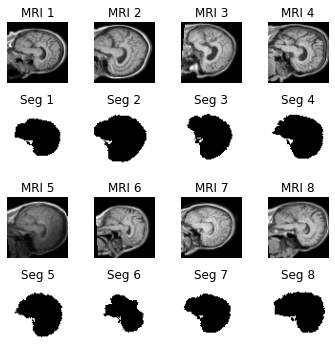

In [ ]:
visualize_batch(c1_train_dataloader)

#### Results

  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  21.526750564575195
train set: Average loss: 0.3563
train set: Average dice: 0.7870




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2764
validate set: Average dice: 0.8695




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  22.281615018844604
train set: Average loss: 0.2660
train set: Average dice: 0.8917




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2326
validate set: Average dice: 0.9117




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  21.544883728027344
train set: Average loss: 0.2241
train set: Average dice: 0.9106




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1936
validate set: Average dice: 0.9373




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  22.029775619506836
train set: Average loss: 0.1889
train set: Average dice: 0.9202




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1818
validate set: Average dice: 0.9497




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  21.5371732711792
train set: Average loss: 0.1618
train set: Average dice: 0.9290




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1390
validate set: Average dice: 0.9546




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  21.86759877204895
train set: Average loss: 0.1352
train set: Average dice: 0.9390




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1244
validate set: Average dice: 0.9558




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  23.21802854537964
train set: Average loss: 0.1161
train set: Average dice: 0.9472




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1053
validate set: Average dice: 0.9616




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  21.423559188842773
train set: Average loss: 0.1019
train set: Average dice: 0.9483




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0950
validate set: Average dice: 0.9609




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  22.04344081878662
train set: Average loss: 0.0891
train set: Average dice: 0.9516




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0782
validate set: Average dice: 0.9666




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  23.26582145690918
train set: Average loss: 0.0784
train set: Average dice: 0.9544




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0749
validate set: Average dice: 0.9581




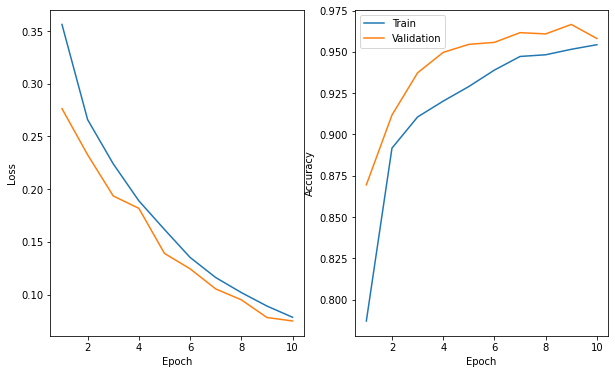

<All keys matched successfully>

In [ ]:
best_val_loss = float('inf')
c1_net = get_model()
optimizer = optim.Adam(c1_net.parameters(), lr=Params['lr'], betas=Params['beta'], weight_decay=Params['regularisation'])
losses = []
end_epoch = Params['n_Epochs']

# Choose a path to save the best model
best_c1_path = "best_c1.pth"

for epoch in range(1, Params['n_Epochs']+1):
    train_loss, train_acc = run(c1_net, c1_train_dataloader, optimizer, Params['loss'], epoch, mode="train")
    val_loss, val_acc = run(c1_net, c1_val_dataloader, optimizer, Params['loss'], epoch, mode="validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
        
        # Save the best model
        torch.save(c1_net.state_dict(), best_c1_path)
        
    else:
        num_epochs_since_best += 1
        
    if num_epochs_since_best >= Params['stop']:
        print(f"Validation loss has not improved for {Params['stop']} epochs, stopping training.")
        end_epoch = epoch
        break

plot_loss_acc(losses, end_epoch)
c1_net.load_state_dict(torch.load(best_c1_path))

#### Visualize predicted segmentation

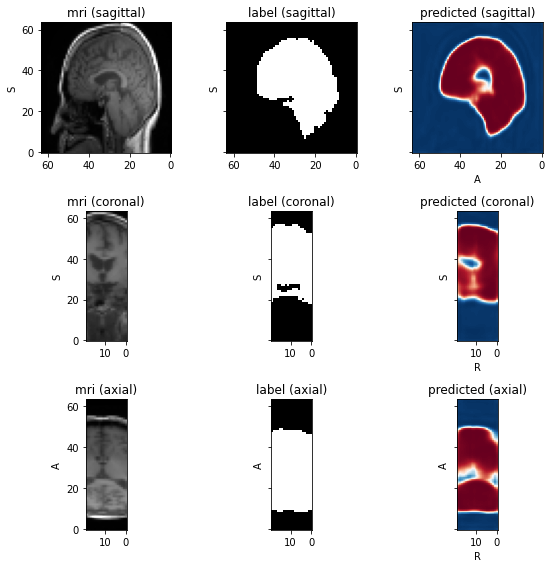

In [ ]:
visualize_prediction(c1_net,  c1_val_dataloader)


### 3.2. Training from Scratch
Here, we train a model from scratch on the target domain (HH with a 3T scanner) using limited data. This approach investigates the potential of training a model without leveraging any information from the source domain.


In [ ]:
c2_train_subjects, c2_val_subjects = split_dataset(target_subjects)
c2_training_set = tio.SubjectsDataset(c2_train_subjects, transform=training_transform)
c2_validation_set = tio.SubjectsDataset(c2_val_subjects, transform=validation_transform)

print('Training set:', len(c2_training_set), 'subjects')
print('Validation set:', len(c2_validation_set), 'subjects')


c2_source_dataloader = torch.utils.data.DataLoader(c2_training_set, batch_size=Params['BATCH_SIZE'], shuffle=True)
c2_target_dataloader = torch.utils.data.DataLoader(c2_validation_set, batch_size=16, shuffle=True)

Training set: 136 subjects
Validation set: 40 subjects


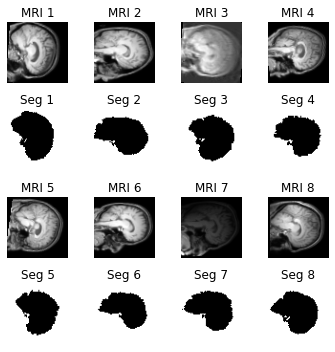

In [ ]:
visualize_batch(c2_source_dataloader)

#### Results

  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.73429822921753
train set: Average loss: 0.3607
train set: Average dice: 0.7153




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.3991
validate set: Average dice: 0.5590




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  7.739137649536133
train set: Average loss: 0.2771
train set: Average dice: 0.8971




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2866
validate set: Average dice: 0.8810




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.07178783416748
train set: Average loss: 0.2501
train set: Average dice: 0.9136




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2540
validate set: Average dice: 0.9491




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  7.926969051361084
train set: Average loss: 0.2289
train set: Average dice: 0.9214




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2295
validate set: Average dice: 0.9483




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.143112659454346
train set: Average loss: 0.2107
train set: Average dice: 0.9250




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1990
validate set: Average dice: 0.9467




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.386510133743286
train set: Average loss: 0.1925
train set: Average dice: 0.9302




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1989
validate set: Average dice: 0.9540




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.20118260383606
train set: Average loss: 0.1814
train set: Average dice: 0.9269




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1861
validate set: Average dice: 0.9574




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  7.854990482330322
train set: Average loss: 0.1645
train set: Average dice: 0.9365




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1740
validate set: Average dice: 0.9520




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  7.977513790130615
train set: Average loss: 0.1517
train set: Average dice: 0.9379




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1467
validate set: Average dice: 0.9642




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  8.719155311584473
train set: Average loss: 0.1403
train set: Average dice: 0.9408




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1449
validate set: Average dice: 0.9600




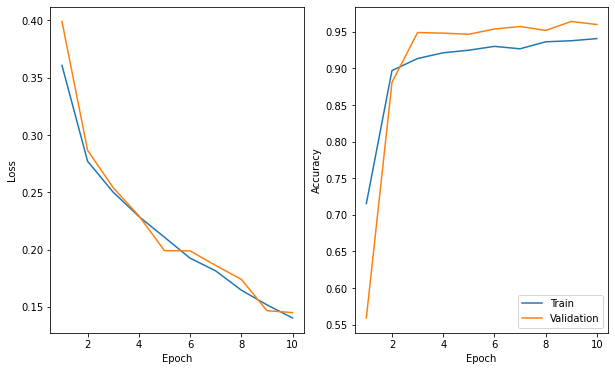

<All keys matched successfully>

In [ ]:
best_val_loss = float('inf')
c2_net = get_model()
optimizer = optim.Adam(c2_net.parameters(), lr=Params['lr'], betas=Params['beta'], weight_decay=Params['regularisation'])
losses = []
end_epoch = Params['n_Epochs']

# Choose a path to save the best model
best_c2_path = "best_c2.pth"

for epoch in range(1, Params['n_Epochs']+1):
    train_loss, train_acc = run(c2_net, c2_source_dataloader, optimizer, Params['loss'], epoch, mode="train")
    val_loss, val_acc = run(c2_net, c2_target_dataloader, optimizer, Params['loss'], epoch, mode="validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
        
        # Save the best model
        torch.save(c2_net.state_dict(), best_c2_path)
        
    else:
        num_epochs_since_best += 1
        
    if num_epochs_since_best >= Params['stop']:
        print(f"Validation loss has not improved for {Params['stop']} epochs, stopping training.")
        end_epoch = epoch
        break

plot_loss_acc(losses, end_epoch)
c2_net.load_state_dict(torch.load(best_c2_path))

#### Visualize predicted segmentation

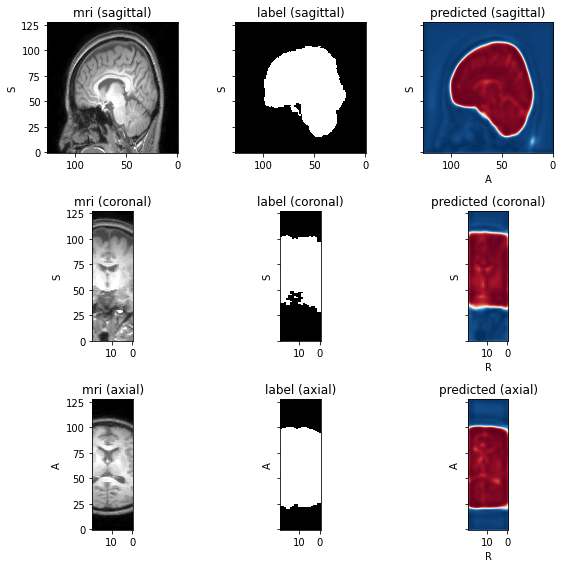

In [ ]:
visualize_prediction(c2_net,  c2_target_dataloader)


### 3.3. Transfer Learning & Fine-tuning on Target Domain
In this technique, we first train a model on the source domain (Guys and IOP with 1.5T scanners). Then, we apply transfer learning to fine-tune the model on the target domain (HH with a 3T scanner). The aim is to leverage the knowledge gained from the source domain and adapt it to the target domain with much less computational resource used


In [ ]:
selected_subjects = []

# Sample subjects with replacement
for _ in range(200):
    index = random.randint(0, len(target_subjects) - 1)
    selected_subjects.append(target_subjects[index])

c3_train_subjects, c3_val_subjects = split_dataset(selected_subjects)
c3_training_set = tio.SubjectsDataset(c3_train_subjects, transform=training_transform)
c3_validation_set = tio.SubjectsDataset(c3_val_subjects, transform=validation_transform)

print('Training set:', len(c3_training_set), 'subjects')
print('Validation set:', len(c3_validation_set), 'subjects')

c3_source_dataloader = torch.utils.data.DataLoader(c3_training_set, batch_size=Params['BATCH_SIZE'], shuffle=True)
c3_target_dataloader = torch.utils.data.DataLoader(c3_validation_set, batch_size=16, shuffle=True)

Training set: 160 subjects
Validation set: 40 subjects


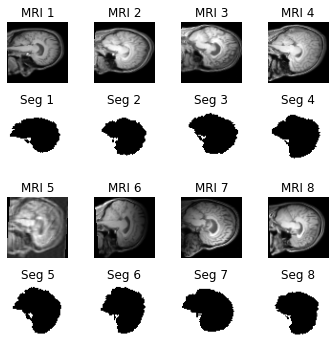

In [ ]:
visualize_batch(c3_source_dataloader)

#### Results

In [ ]:
c3_net = get_model()
c3_net.load_state_dict(torch.load(best_c1_path))
for name, param in c3_net.named_parameters():
  if 'classifier' not in name: 
    param.requires_grad = False

  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  9.522979974746704
train set: Average loss: 0.1047
train set: Average dice: 0.9534




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0839
validate set: Average dice: 0.9650




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  9.480607271194458
train set: Average loss: 0.1046
train set: Average dice: 0.9538




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0828
validate set: Average dice: 0.9658




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  9.43330192565918
train set: Average loss: 0.1028
train set: Average dice: 0.9549




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0817
validate set: Average dice: 0.9666




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  9.385410785675049
train set: Average loss: 0.1034
train set: Average dice: 0.9544




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0810
validate set: Average dice: 0.9669




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  9.502311706542969
train set: Average loss: 0.1076
train set: Average dice: 0.9521




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0817
validate set: Average dice: 0.9667




  0%|          | 0/5 [00:00<?, ?it/s]

Time for epoch =  10.15846848487854
train set: Average loss: 0.1012
train set: Average dice: 0.9550




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0826
validate set: Average dice: 0.9660


Validation loss has not improved for 2 epochs, stopping training.


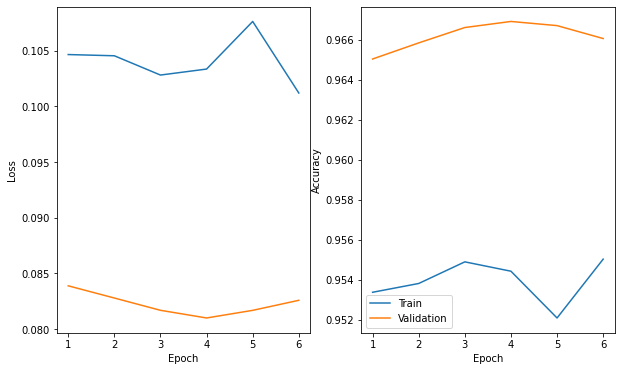

<All keys matched successfully>

In [ ]:
best_val_loss = float('inf')
optimizer = optim.Adam(c3_net.classifier.parameters(), lr=Params['lr']/100, betas=Params['beta'], weight_decay=Params['regularisation']) # Smaller LR for transfer learning since the original model did well
losses = []
end_epoch = Params['n_Epochs']

# Choose a path to save the best model
best_c3_path = "best_c3.pth"

for epoch in range(1, Params['n_Epochs']+1):
    train_loss, train_acc = run(c3_net, c3_source_dataloader, optimizer, nn.CrossEntropyLoss(), epoch, mode="train")
    val_loss, val_acc = run(c3_net, c3_target_dataloader, optimizer, nn.CrossEntropyLoss(), epoch, mode="validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
        
        # Save the best model
        torch.save(c3_net.state_dict(), best_c3_path)
        
    else:
        num_epochs_since_best += 1
        
    if num_epochs_since_best >= Params['stop']:
        print(f"Validation loss has not improved for {Params['stop']} epochs, stopping training.")
        end_epoch = epoch
        break

plot_loss_acc(losses, end_epoch)
c3_net.load_state_dict(torch.load(best_c3_path))

#### Visualize predicted segmentation

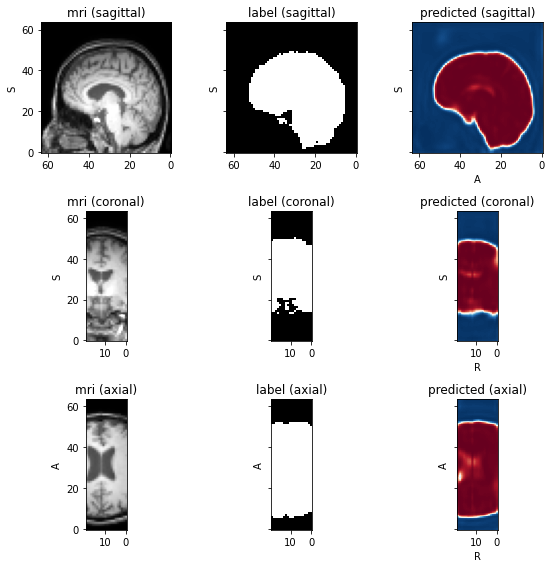

In [ ]:
visualize_prediction(c3_net,  c3_target_dataloader)


### 3.4. Normalized Data via [`HistogramStandardization`](https://torchio.readthedocs.io/transforms/preprocessing.html#histogramstandardization)
In this approach, we train a model on all the data from the three hospitals, with intensity normalization applied. We investigate the impact of intensity normalization on the model's performance and generalization in the target domain (HH with a 3T scanner).


In [ ]:
c4_train_subjects, c4_val_subjects = split_dataset(source_subjects)
c4_training_set = tio.SubjectsDataset(c4_train_subjects, transform=training_transform_w_hstd)
c4_validation_set = tio.SubjectsDataset(c4_val_subjects, transform=validation_transform_w_hstd)

print('Training set:', len(c4_training_set), 'subjects')
print('Validation set:', len(c4_validation_set), 'subjects')

c4_train_dataloader = torch.utils.data.DataLoader(c4_training_set, batch_size=Params['BATCH_SIZE'], shuffle=True)
c4_val_dataloader = torch.utils.data.DataLoader(c4_validation_set, batch_size=16, shuffle=True)

Training set: 348 subjects
Validation set: 40 subjects


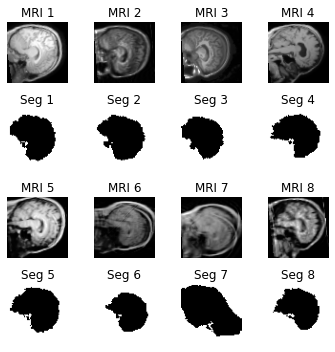

In [ ]:
visualize_batch(c4_train_dataloader)

#### Results

  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  24.967785596847534
train set: Average loss: 0.2653
train set: Average dice: 0.8072




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.2443
validate set: Average dice: 0.8726




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  25.42146873474121
train set: Average loss: 0.1757
train set: Average dice: 0.9011




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1729
validate set: Average dice: 0.9046




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  25.308048725128174
train set: Average loss: 0.1443
train set: Average dice: 0.9164




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1399
validate set: Average dice: 0.9530




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  23.962923288345337
train set: Average loss: 0.1214
train set: Average dice: 0.9261




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1095
validate set: Average dice: 0.9556




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  24.013627290725708
train set: Average loss: 0.1036
train set: Average dice: 0.9341




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.1025
validate set: Average dice: 0.9529




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  25.06960892677307
train set: Average loss: 0.0911
train set: Average dice: 0.9388




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0850
validate set: Average dice: 0.9559




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  25.32567596435547
train set: Average loss: 0.0784
train set: Average dice: 0.9460




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0803
validate set: Average dice: 0.9485




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  24.97257113456726
train set: Average loss: 0.0683
train set: Average dice: 0.9520




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0678
validate set: Average dice: 0.9526




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  25.12503671646118
train set: Average loss: 0.0639
train set: Average dice: 0.9509




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0508
validate set: Average dice: 0.9648




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  24.591922283172607
train set: Average loss: 0.0575
train set: Average dice: 0.9548




  0%|          | 0/3 [00:00<?, ?it/s]

validate set: Average loss: 0.0488
validate set: Average dice: 0.9688




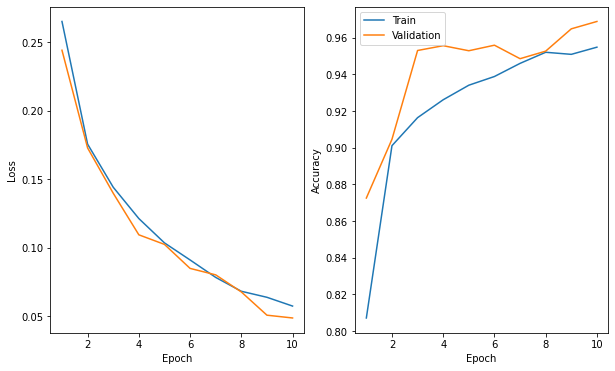

<All keys matched successfully>

In [ ]:
best_val_loss = float('inf')
c4_net = get_model()
optimizer = optim.Adam(c4_net.parameters(), lr=Params['lr'], betas=Params['beta'], weight_decay=Params['regularisation'])
losses = []
end_epoch = Params['n_Epochs']

# Choose a path to save the best model
best_c4_path = "best_c4.pth"

for epoch in range(1, Params['n_Epochs']+1):
    train_loss, train_acc = run(c4_net, c4_train_dataloader, optimizer, Params['loss'], epoch, mode="train")
    val_loss, val_acc = run(c4_net, c4_val_dataloader, optimizer, Params['loss'], epoch, mode="validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
        
        # Save the best model
        torch.save(c4_net.state_dict(), best_c4_path)
        
    else:
        num_epochs_since_best += 1
        
    if num_epochs_since_best >= Params['stop']:
        print(f"Validation loss has not improved for {Params['stop']} epochs, stopping training.")
        end_epoch = epoch
        break

plot_loss_acc(losses, end_epoch)
c4_net.load_state_dict(torch.load(best_c4_path))

#### Visualize predicted segmentation

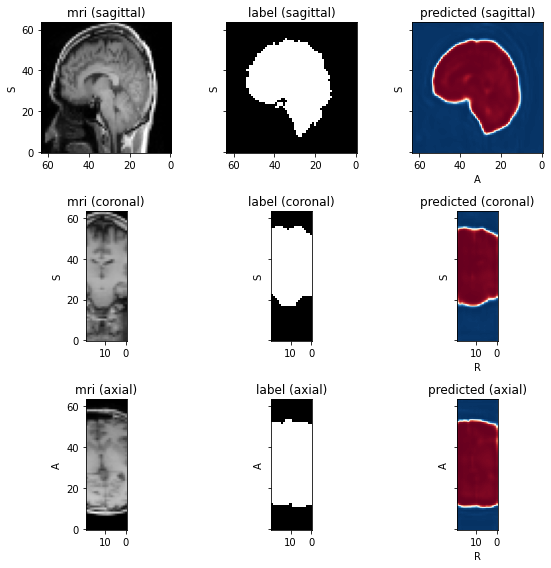

In [ ]:
visualize_prediction(c4_net,  c4_val_dataloader)


## 4. Evaluation Metrics
To evaluate the performance of the models and their generalization across domains, we will use various metrics, such as Dice coefficient and efficiency


#### Create test dataset 

We use a combination of sampling with replacement and applying transformations to augment the data

In [ ]:
import random

target_dataset_length = len(target_subjects)
num_test_subjects = Params['test_len']
selected_subjects = []

# Sample subjects with replacement
for _ in range(num_test_subjects):
    index = random.randint(0, target_dataset_length - 1)
    selected_subjects.append(target_subjects[index])

# Apply transformations to create the test dataset
test_dataset = tio.SubjectsDataset(selected_subjects, transform=testing_transform)
test_dataset_w_hstd = tio.SubjectsDataset(selected_subjects, transform=testing_transform)
print('Testing set:', len(test_dataset), 'subjects')


Testing set: 100 subjects


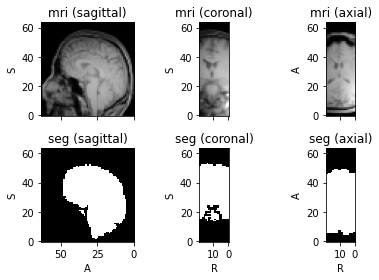

In [ ]:
test_transform_subject = testing_transform(one_target)
test_transform_subject.plot()

#### Compare

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
test_dataloader_w_hstd = torch.utils.data.DataLoader(test_dataset_w_hstd, batch_size=16, shuffle=False)
# Load the trained models
model_paths = ['best_c1.pth', 'best_c2.pth', 'best_c3.pth', 'best_c4.pth']
models = [c1_net, c2_net, c3_net, c4_net]

for i, model_path in enumerate(model_paths):
    models[i].load_state_dict(torch.load(model_path))

# Test each model and print the loss and accuracy
for i, model in enumerate(models):
    print(f"Testing model c{i+1}:")
    if i == 3 :
      loader = test_dataloader_w_hstd
    else:
      loader = test_dataloader
    loss, acc = run(model, loader, None, Params['loss'], 1, mode='test')
    print(f"Model c{i+1} - Accuracy: {acc:.4f}\n")



Testing model c1:


  0%|          | 0/7 [00:00<?, ?it/s]

test set: Average loss: 0.1741
test set: Average dice: 0.8054


Model c1 - Accuracy: 0.8054

Testing model c2:


  0%|          | 0/7 [00:00<?, ?it/s]

test set: Average loss: 0.1846
test set: Average dice: 0.8657


Model c2 - Accuracy: 0.8657

Testing model c3:


  0%|          | 0/7 [00:00<?, ?it/s]

test set: Average loss: 0.1175
test set: Average dice: 0.8913


Model c3 - Accuracy: 0.8913

Testing model c4:


  0%|          | 0/7 [00:00<?, ?it/s]

test set: Average loss: 0.0642
test set: Average dice: 0.9469


Model c4 - Accuracy: 0.9469



## 5. Domain Invariant Learning with Maximum Mean Discrepency Loss

In this section, we develop Maximum Mean Discrepancy (MMD) as a regularizer in the loss function, which helps minimize the difference between the source and target domain feature distributions.

The combination of Dice and Maximum Mean Discrepancy (MMD) loss enables domain-invariant learning by simultaneously optimizing both segmentation performance and domain adaptation in the model. Here's how each component contributes to domain-invariant learning:

Dice Loss: Dice loss is a popular loss function used in segmentation tasks, as it measures the similarity between the predicted segmentation mask and the ground-truth mask. Minimizing Dice loss ensures that the model learns to generate accurate segmentation masks, considering both the overlap and size of the predicted and ground-truth regions. In other words, Dice loss focuses on the task-specific performance of the model.

MMD Loss: MMD is a kernel-based method that measures the distance between the feature distributions of the source and target domains. By minimizing MMD loss, the model learns to generate domain-invariant features, meaning that the features extracted from both domains become indistinguishable. This domain adaptation helps the model generalize better to the target domain, reducing the impact of domain shift on the model's performance.

By combining Dice and MMD loss, the model is trained to optimize both segmentation performance (through Dice loss) and domain adaptation (through MMD loss) simultaneously. This dual optimization enables domain-invariant learning, as the model learns to generate accurate segmentation masks while also reducing the discrepancies between the source and target domain features. As a result, the model is more likely to generalize well to the target domain, achieving better performance compared to methods that do not consider domain adaptation.


### 5.1 Kernel: Define the kernel function to be used in the MMD loss calculation. The kernel function measures the feature representations. We will use  Gaussian (RBF) kernel based on this [`paper`](https://arxiv.org/abs/1505.03906). The formula is given by:

$$k(x, x_0) = \exp\left(-\frac{1}{2\sigma^2}\lVert x - x_0 \rVert^2\right)
$$

In [ ]:
def gaussian_kernel(x, y, sigma=1.0):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1) * x.size(2) * x.size(3) * x.size(4)

    x = x.view(x_size, -1)
    y = y.view(y_size, -1)

    tiled_x = x.view(x_size, 1, -1).expand(x_size, y_size, dim)
    tiled_y = y.view(1, y_size, -1).expand(x_size, y_size, dim)

    distances = ((tiled_x - tiled_y) ** 2).sum(dim=2)
    return torch.exp(-distances / (2 * sigma ** 2))


### 5.2 MMD Loss: Implement the Maximum Mean Discrepancy (MMD) loss that measures the difference between the distributions of source and target feature representations. Based on this [`paper`](https://arxiv.org/abs/0805.2368). The formula is given by: 

$$\mathcal{L}_{MMD}^2(X, Y) = \frac{1}{N^2} \sum_{i=1}^{N} \sum_{i_0=1}^{N} k(x_i, x_{i_0}) + \frac{1}{M^2} \sum_{j=1}^{M} \sum_{j_0=1}^{M} k(y_j, y_{j_0}) - \frac{2}{NM} \sum_{i=1}^{N} \sum_{j=1}^{M} k(x_i, y_j)
$$

In [ ]:
def mmd_loss(source_features, target_features, sigma=1.0):
    xx_kernel = gaussian_kernel(source_features, source_features, sigma)
    xy_kernel = gaussian_kernel(source_features, target_features, sigma)
    yy_kernel = gaussian_kernel(target_features, target_features, sigma)

    mmd = xx_kernel.mean() + yy_kernel.mean() - 2 * xy_kernel.mean()
    return mmd



$$\mathcal{L} = \mathcal{L}_{dice} + \lambda \mathcal{L}_{MMD}^2(h_{\theta}^{encoder}(x_{source}), h_{\theta}^{encoder}(x_{target}))$$

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, epsilon=1e-9, alpha=0.1):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(epsilon)
        self.alpha = alpha

    def forward(self, pred, target, source_features, target_features):
        dice = self.dice_loss(pred, target)
        mmd = mmd_loss(source_features, target_features)
        total_loss = dice + self.alpha * mmd
        return total_loss

### 5.3 Modified U-Net: Modify the U-Net architecture to return intermediate feature representations along with the segmentation output.

In [ ]:
class ModifiedUNet(UNet):
    def _get_encoding_block_outputs(self, x):
        for encoding_block in self.encoder.encoding_blocks:
            x, _ = encoding_block(x)
        return self.bottom_block(x)

    def forward(self, x):
        # Get the intermediate features
        features = self._get_encoding_block_outputs(x)
        # Get the final predictions
        predictions = super().forward(x)

        return predictions, features

def get_modified_model():
    model = ModifiedUNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )
    return model


### 5.4 Result: Train the modified U-Net model using a combined loss function (Dice loss + MMD loss). 

#### Modified train and validate

In [ ]:
def modified_run(run_net, source_dataloader, target_dataloader, run_optim, loss_func, curr_epoch, mode ='train'):
    run_net = run_net.to(device)
    loss_func = loss_func.to(device)
    total_loss = 0
    pred_store = []
    true_store = []
    batches = 0
    t0 = time.time()
    
    if mode == 'train':
        run_net.train()
    else:
        run_net.eval()
    for batch_idx, source_batch in enumerate(tqdm(source_dataloader)):
        target_batch = next(iter(target_dataloader))
        source_data, source_target = source_batch['mri'][tio.DATA], source_batch['seg'][tio.DATA]
        target_data, target_target = target_batch['mri'][tio.DATA], target_batch['seg'][tio.DATA]

        batches += 1
        source_inputs = source_data.to(device)
        source_output_labels = source_target.to(device)
        target_inputs = target_data.to(device)
        target_output_labels = target_target.to(device)

        run_optim.zero_grad()

        source_pred, source_features = run_net(source_inputs)
        target_pred, target_features = run_net(target_inputs)

        loss = loss_func(source_pred, source_output_labels, source_features, target_features)

        if mode == 'train':
            loss.backward()
            run_optim.step()

        total_loss += loss
        pred_store.append(np.argmax(source_pred.detach().cpu().numpy(), axis=1))
        true_store.append(np.argmax(source_output_labels.detach().cpu().numpy(), axis=1))

    t1 = time.time()

    av_loss = total_loss / batches
    total_time = t1-t0
    print('Time for epoch = ', total_time)

    av_loss = av_loss.detach().cpu().numpy()
    dice_scores = get_dice_score_list(pred_store, true_store)
    acc = sum(dice_scores) / len(dice_scores)

    print(mode + ' set: Average loss: {:.4f}'.format(av_loss,  flush=True))
    print(mode + ' set: Average dice: {:.4f}'.format(acc,  flush=True))
    print('\n')

    return av_loss, acc


#### Create target dataset with same number of subjects as source dataset

In [ ]:
target_dataset_length = len(target_subjects)
num_test_subjects = len(source_subjects)
modified_target_subjects = []

# Sample subjects with replacement
for _ in range(num_test_subjects):
    index = random.randint(0, target_dataset_length - 1)
    modified_target_subjects.append(target_subjects[index])

In [ ]:
c5_train_source_subjects, c5_val_source_subjects = split_dataset(source_subjects)
c5_train_target_subjects, c5_val_target_subjects = split_dataset(modified_target_subjects)
c5_train_source_dataset = tio.SubjectsDataset(c5_train_source_subjects, transform=testing_transform)
c5_train_target_dataset = tio.SubjectsDataset(c5_train_target_subjects, transform=testing_transform)
c5_val_source_dataset = tio.SubjectsDataset(c5_val_source_subjects, transform=validation_transform)
c5_val_target_dataset = tio.SubjectsDataset(c5_val_target_subjects, transform=validation_transform)
print('Training source set:', len(c5_train_source_dataset), 'subjects')
print('Training target set:', len(c5_train_target_dataset), 'subjects')
print('Validation source set:', len(c5_val_source_dataset), 'subjects')
print('Validation target set:', len(c5_val_target_dataset), 'subjects')

c5_train_source_dataloader = torch.utils.data.DataLoader(c5_train_source_dataset, batch_size=Params['BATCH_SIZE'], shuffle=True)
c5_train_target_dataloader = torch.utils.data.DataLoader(c5_train_target_dataset, batch_size=Params['BATCH_SIZE'], shuffle=True)
c5_val_source_dataloader = torch.utils.data.DataLoader(c5_val_source_dataset, batch_size=16, shuffle=True)
c5_val_target_dataloader = torch.utils.data.DataLoader(c5_val_target_dataset, batch_size=16, shuffle=True)

Training source set: 348 subjects
Training target set: 348 subjects
Validation source set: 40 subjects
Validation target set: 40 subjects


#### Visualize the difference in intensity distribution

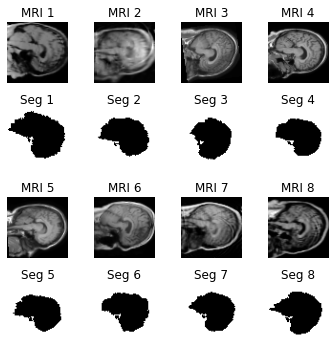

In [ ]:
visualize_batch(c5_train_source_dataloader)

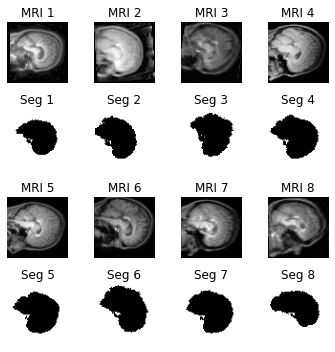

In [ ]:
visualize_batch(c5_train_target_dataloader)

#### Train the modified U-net with modified loss

  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  44.8414671421051
train set: Average loss: 0.3403
train set: Average dice: 0.7673




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.76911997795105
validate set: Average loss: 0.2439
validate set: Average dice: 0.9297




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  44.72028636932373
train set: Average loss: 0.2503
train set: Average dice: 0.9053




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.6427347660064697
validate set: Average loss: 0.2125
validate set: Average dice: 0.9458




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.70802450180054
train set: Average loss: 0.2066
train set: Average dice: 0.9224




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.5803983211517334
validate set: Average loss: 0.1933
validate set: Average dice: 0.9518




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.397170305252075
train set: Average loss: 0.1735
train set: Average dice: 0.9319




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.538064479827881
validate set: Average loss: 0.1718
validate set: Average dice: 0.9511




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  46.06963300704956
train set: Average loss: 0.1457
train set: Average dice: 0.9410




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.651012420654297
validate set: Average loss: 0.1430
validate set: Average dice: 0.9538




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.464844703674316
train set: Average loss: 0.1241
train set: Average dice: 0.9469




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.5783884525299072
validate set: Average loss: 0.1126
validate set: Average dice: 0.9610




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  46.07140111923218
train set: Average loss: 0.1073
train set: Average dice: 0.9515




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.651872158050537
validate set: Average loss: 0.1009
validate set: Average dice: 0.9632




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.43189597129822
train set: Average loss: 0.0944
train set: Average dice: 0.9539




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.6124582290649414
validate set: Average loss: 0.0905
validate set: Average dice: 0.9633




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.13669443130493
train set: Average loss: 0.0840
train set: Average dice: 0.9564




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.629368543624878
validate set: Average loss: 0.0792
validate set: Average dice: 0.9693




  0%|          | 0/11 [00:00<?, ?it/s]

Time for epoch =  45.8341851234436
train set: Average loss: 0.0775
train set: Average dice: 0.9559




  0%|          | 0/3 [00:00<?, ?it/s]

Time for epoch =  2.709002733230591
validate set: Average loss: 0.0720
validate set: Average dice: 0.9667




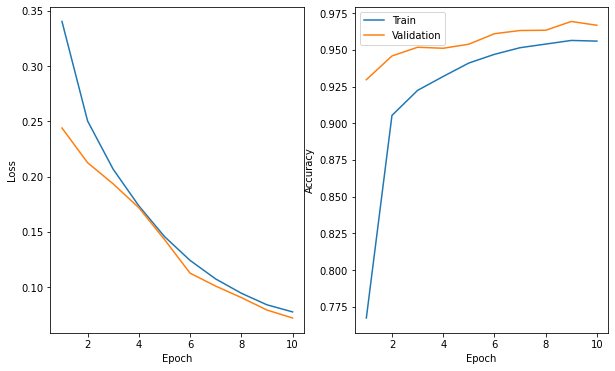

<All keys matched successfully>

In [ ]:
best_val_loss = float('inf')
c5_net = get_modified_model()
optimizer = optim.Adam(c5_net.parameters(), lr=Params['lr'], betas=Params['beta'], weight_decay=Params['regularisation'])
losses = []
end_epoch = Params['n_Epochs']

# Choose a path to save the best model
best_c5_path = "best_c5.pth"

for epoch in range(1, Params['n_Epochs']+1):
    train_loss, train_acc = modified_run(c5_net, c5_train_source_dataloader, c5_train_target_dataloader, optimizer, CombinedLoss(), epoch, mode="train")
    val_loss, val_acc = modified_run(c5_net, c5_val_source_dataloader, c5_val_target_dataloader, optimizer, CombinedLoss(), epoch, mode="validate")
    losses.append([train_loss, train_acc, val_loss, val_acc])
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        num_epochs_since_best = 0
        
        # Save the best model
        torch.save(c5_net.state_dict(), best_c5_path)
        
    else:
        num_epochs_since_best += 1
        
    if num_epochs_since_best >= Params['stop']:
        print(f"Validation loss has not improved for {Params['stop']} epochs, stopping training.")
        end_epoch = epoch
        break

plot_loss_acc(losses, end_epoch)
c5_net.load_state_dict(torch.load(best_c5_path))


#### Visualize Results

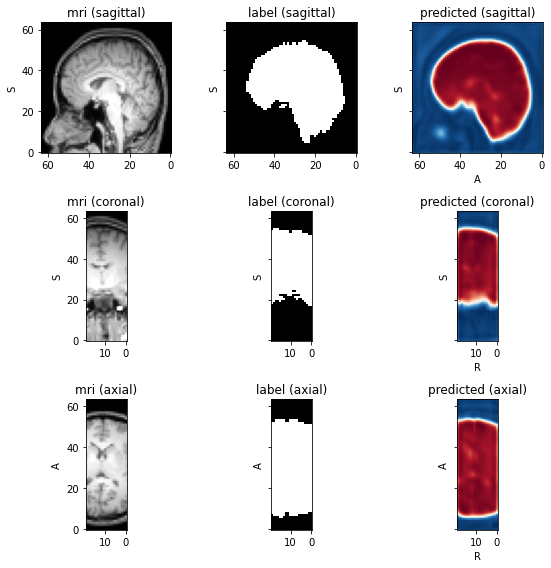

In [ ]:
visualize_prediction(c5_net,  c5_val_target_dataloader)

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)
loss, acc = modified_run(c5_net, test_dataloader, test_dataloader, optimizer, CombinedLoss(), 1, mode='test')
print(f"Model c5 - Accuracy: {acc:.4f}\n")

  0%|          | 0/7 [00:00<?, ?it/s]

Time for epoch =  13.394702196121216
test set: Average loss: 0.0767
test set: Average dice: 0.9581


Model c5 - Accuracy: 0.9581




## 6. Conclusion
In this section, we present the results of the experiments, comparing the performance of the different training strategies and domain adaptation techniques. We analyze the effectiveness of each approach and its impact on the generalization of the models across different scanners.



1. Direct Transfer (c1) - Accuracy: 0.8054, Time per Epoch: 23 seconds

In this approach, a pre-trained model from the source dataset (388 subjects) is directly applied to the target dataset (176 subjects) without any additional training. This method is quick and requires no additional data for training but can result in reduced performance due to the domain shift.

2. Training from Scratch (c2) - Accuracy: 0.8657, Time per Epoch: 9 seconds

The model is trained entirely on the target dataset (176 subjects), disregarding any pre-trained knowledge from the source dataset. This method can be time-consuming but achieves better performance than direct transfer. However, it may require a larger target dataset for optimal results.

3. Transfer Learning (c3) - Accuracy: 0.8913, Time per Epoch: 9.5 seconds

A pre-trained model from the source dataset (388 subjects) is fine-tuned on the target dataset (176 subjects). This method combines the benefits of both direct transfer and training from scratch, achieving better performance.

4. Histogram Normalization (c4) - Accuracy: 0.9469, Time per Epoch: 25 seconds

This method involves matching the intensity distribution of the source and target datasets through histogram normalization before applying the model. It improves the performance compared to the previous methods but requires additional pre-processing steps which takes additional computational resources.

5. MMD Loss (c5) - Accuracy: 0.9581, Time per Epoch: 22 seconds

The model is trained by minimizing combined loss of dice loss and the Maximum Mean Discrepancy (MMD) loss, which measures the distance between the source and target domain feature distributions. This method achieves the highest accuracy and has comparable computation time to histogram normalization (with pre-processing).

In summary, combined loss offers the best performance with the highest accuracy and takes advantage of the combined dataset for training. It also has a similar computation time to the histogram normalization method while offering better accuracy.